# FIGURE 1

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns; sns.set(color_codes=True)
from msresist.pre_processing import preprocessing, LinearFoldChange, FoldChangeToControl, MapOverlappingPeptides, BuildMatrix, CorrCoefFilter, TripsMeanAndStd, FilterByStdev, MergeDfbyMean
from msresist.sequence_analysis import GeneratingKinaseMotifs, FormatName, FormatSeq
import warnings
warnings.simplefilter("ignore")

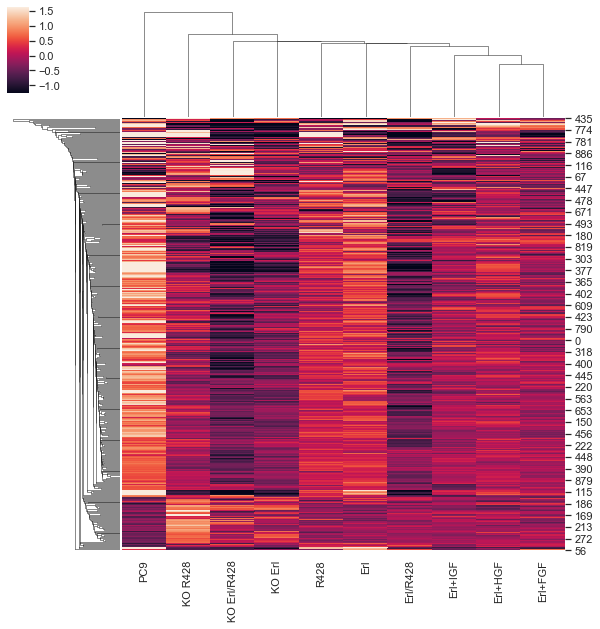

In [2]:
ABC_mc = preprocessing(motifs=True, FCfilter=True, log2T=True)

sns.clustermap(ABC_mc.iloc[:, 2:], method = "single", robust=True)